In [7]:
import tensorflow as tf
import zhusuan as zs
import numpy as np


class ScoreEstimator(object):
    def __init__(self):
        pass

    def rbf_kernel(self, x1, x2, kernel_width):
        return tf.exp(-tf.reduce_sum(tf.square(x1 - x2), axis=-1) / (2 * tf.square(kernel_width)))

    def gram(self, x1, x2, kernel_width):
        # x1: [..., n1, x_dim]
        # x2: [..., n2, x_dim]
        # kernel_width: [...]
        # return: [..., n1, n2]
        x_row = tf.expand_dims(x1, -2)
        x_col = tf.expand_dims(x2, -3)
        kernel_width = kernel_width[..., None, None]
        return self.rbf_kernel(x_row, x_col, kernel_width)

    def grad_gram(self, x1, x2, kernel_width):
        # x1: [..., n1, x_dim]
        # x2: [..., n2, x_dim]
        # kernel_width: [...]
        # return gram, grad_x1, grad_x2:
        #   [..., n1, n2], [..., n1, n2, x_dim], [..., n1, n2, x_dim]
        x_row = tf.expand_dims(x1, -2)
        x_col = tf.expand_dims(x2, -3)
        kernel_width = kernel_width[..., None, None]
        # G: [..., n1, n2]
        G = self.rbf_kernel(x_row, x_col, kernel_width)
        # diff: [..., n1, n2, n_x]
        diff = (x_row - x_col) / (kernel_width[..., None] ** 2)
        # G_expand: [..., n1, n2, 1]
        G_expand = tf.expand_dims(G, axis=-1)
        # grad_x1: [..., n1, n2, n_x]
        grad_x2 = G_expand * diff
        # grad_x2: [..., n1, n2, n_x]
        grad_x1 = G_expand * (-diff)
        return G, grad_x1, grad_x2

    def heuristic_kernel_width(self, x_samples, x_basis):
        # x_samples: [..., n_samples, x_dim]
        # x_basis: [..., n_basis, x_dim]
        # return: [...]
        n_samples = tf.shape(x_samples)[-2]
        n_basis = tf.shape(x_basis)[-2]
        x_samples_expand = tf.expand_dims(x_samples, -2)
        x_basis_expand = tf.expand_dims(x_basis, -3)
        pairwise_dist = tf.sqrt(
            tf.reduce_sum(tf.square(x_samples_expand - x_basis_expand),
                          axis=-1))
        k = n_samples * n_basis // 2
        top_k_values = tf.nn.top_k(
            tf.reshape(pairwise_dist, [-1, n_samples * n_basis]),
            k=k).values
        kernel_width = tf.reshape(top_k_values[:, -1], tf.shape(x_samples)[:-2])
        # kernel_width = tf.Print(kernel_width, [kernel_width], message="kernel_width: ")
        return tf.stop_gradient(kernel_width)

    def compute_gradients(self, samples, x=None):
        raise NotImplementedError()

        
class SteinScoreEstimator(ScoreEstimator):
    def __init__(self, eta):
        self._eta = eta
        super(SteinScoreEstimator, self).__init__()

    def compute_gradients(self, samples, x=None):
        # samples: [..., M, x_dim]
        # x: [..., 1, x_dim]
        M = tf.shape(samples)[-2]
        # kernel_width: [...]
        kernel_width = self.heuristic_kernel_width(samples, samples)
        # K: [..., M, M]
        # grad_K1: [..., M, M, x_dim]
        # grad_K2: [..., M, M, x_dim]
        K, grad_K1, grad_K2 = self.grad_gram(samples, samples, kernel_width)
        # K_inv: [..., M, M]
        Kinv = tf.matrix_inverse(K + self._eta * tf.eye(M))
        # H_dh: [..., M, x_dim]
        H_dh = tf.reduce_sum(grad_K2, axis=-2)
        # grads: [..., M, x_dim]
        grads = - tf.matmul(Kinv, H_dh)
        if x is None:
            return grads
        else:
            assert_single_x = tf.assert_equal(
                tf.shape(x)[-2], 1,
                message="Only support single-particle out-of-sample extension.")
            with tf.control_dependencies([assert_single_x]):
                # Kxx: [..., 1, 1]
                Kxx = self.gram(x, x, kernel_width)
            # Kxq: [..., 1, M]
            Kxq = self.gram(x, samples, kernel_width)
            # Kxq @ K_inv: [..., 1, M]
            KxqKinv = tf.matmul(Kxq, Kinv)
            # term1: [..., 1, 1]
            term1 = -1. / (Kxx + self._eta - tf.matmul(KxqKinv, Kxq, transpose_b=True))
            # grad_Kqx2: [..., M, 1, x_dim]
            Kqx, grad_Kqx1, grad_Kqx2 = self.grad_gram(samples, x, kernel_width)
            # term2: [..., 1, x_dim]
            term2 = tf.matmul(Kxq, grads) - tf.matmul(KxqKinv + 1., tf.squeeze(grad_Kqx2, -2))
            # ret: [..., 1, x_dim]
            return tf.matmul(term1, term2)

        
class SpectralScoreEstimator(ScoreEstimator):
    def __init__(self, n_eigen=None, eta=None, n_eigen_threshold=None):
        self._n_eigen = n_eigen
        self._eta = eta
        self._n_eigen_threshold = n_eigen_threshold
        super(SpectralScoreEstimator, self).__init__()

    def nystrom_ext(self, samples, x, eigen_vectors, eigen_values, kernel_width):
        # samples: [..., M, x_dim]
        # x: [..., N, x_dim]
        # eigen_vectors: [..., M, n_eigen]
        # eigen_values: [..., n_eigen]
        # return: [..., N, n_eigen], by default n_eigen=M.
        M = tf.shape(samples)[-2]
        # Kxq: [..., N, M]
        # grad_Kx: [..., N, M, x_dim]
        # grad_Kq: [..., N, M, x_dim]
        Kxq = self.gram(x, samples, kernel_width)
        # Kxq = tf.Print(Kxq, [tf.shape(Kxq)], message="Kxq:")
        # ret: [..., N, n_eigen]
        ret = tf.sqrt(tf.to_float(M)) * tf.matmul(Kxq, eigen_vectors)
        ret *= 1. / tf.expand_dims(eigen_values, axis=-2)
        return ret

    def compute_gradients(self, samples, x=None):
        # samples: [..., M, x_dim]
        # x: [..., N, x_dim]
        if x is None:
            kernel_width = self.heuristic_kernel_width(samples, samples)
            # TODO: Simplify computation
            x = samples
        else:
            # _samples: [..., N + M, x_dim]
            _samples = tf.concat([samples, x], axis=-2)
            kernel_width = self.heuristic_kernel_width(_samples, _samples)

        M = tf.shape(samples)[-2]
        # Kq: [..., M, M]
        # grad_K1: [..., M, M, x_dim]
        # grad_K2: [..., M, M, x_dim]
        Kq, grad_K1, grad_K2 = self.grad_gram(samples, samples, kernel_width)
        if self._eta is not None:
            Kq += self._eta * tf.eye(M)
        # eigen_vectors: [..., M, M]
        # eigen_values: [..., M]
        with tf.device("/cpu:0"):
            eigen_values, eigen_vectors = tf.self_adjoint_eig(Kq)
        # eigen_vectors = tf.matrix_inverse(Kq)
        # eigen_values = tf.reduce_sum(Kq, -1)
        # eigen_values = tf.Print(eigen_values, [eigen_values], message="eigen_values:", summarize=20)
        if (self._n_eigen is None) and (self._n_eigen_threshold is not None):
            eigen_arr = tf.reduce_mean(tf.reshape(eigen_values, [-1, M]), axis=0)
            eigen_arr = tf.reverse(eigen_arr, axis=[-1])
            eigen_arr /= tf.reduce_sum(eigen_arr)
            eigen_cum = tf.cumsum(eigen_arr, axis=-1)
            self._n_eigen = tf.reduce_sum(tf.to_int32(tf.less(eigen_cum, self._n_eigen_threshold)))
            # self._n_eigen = tf.Print(self._n_eigen, [self._n_eigen], message="n_eigen:")
        if self._n_eigen is not None:
            # eigen_values: [..., n_eigen]
            # eigen_vectors: [..., M, n_eigen]
            eigen_values = eigen_values[..., -self._n_eigen:]
            eigen_vectors = eigen_vectors[..., -self._n_eigen:]
        # eigen_ext: [..., N, n_eigen]
        eigen_ext = self.nystrom_ext(samples, x, eigen_vectors, eigen_values, kernel_width)
        # grad_K1_avg = [..., M, x_dim]
        grad_K1_avg = tf.reduce_mean(grad_K1, axis=-3)
        # beta: [..., n_eigen, x_dim]
        beta = -tf.sqrt(tf.to_float(M)) * tf.matmul(eigen_vectors, grad_K1_avg, transpose_a=True) / tf.expand_dims(eigen_values, -1)
        # grads: [..., N, x_dim]
        grads = tf.matmul(eigen_ext, beta)
        return grads

Instructions for updating:
Use `tf.cast` instead.


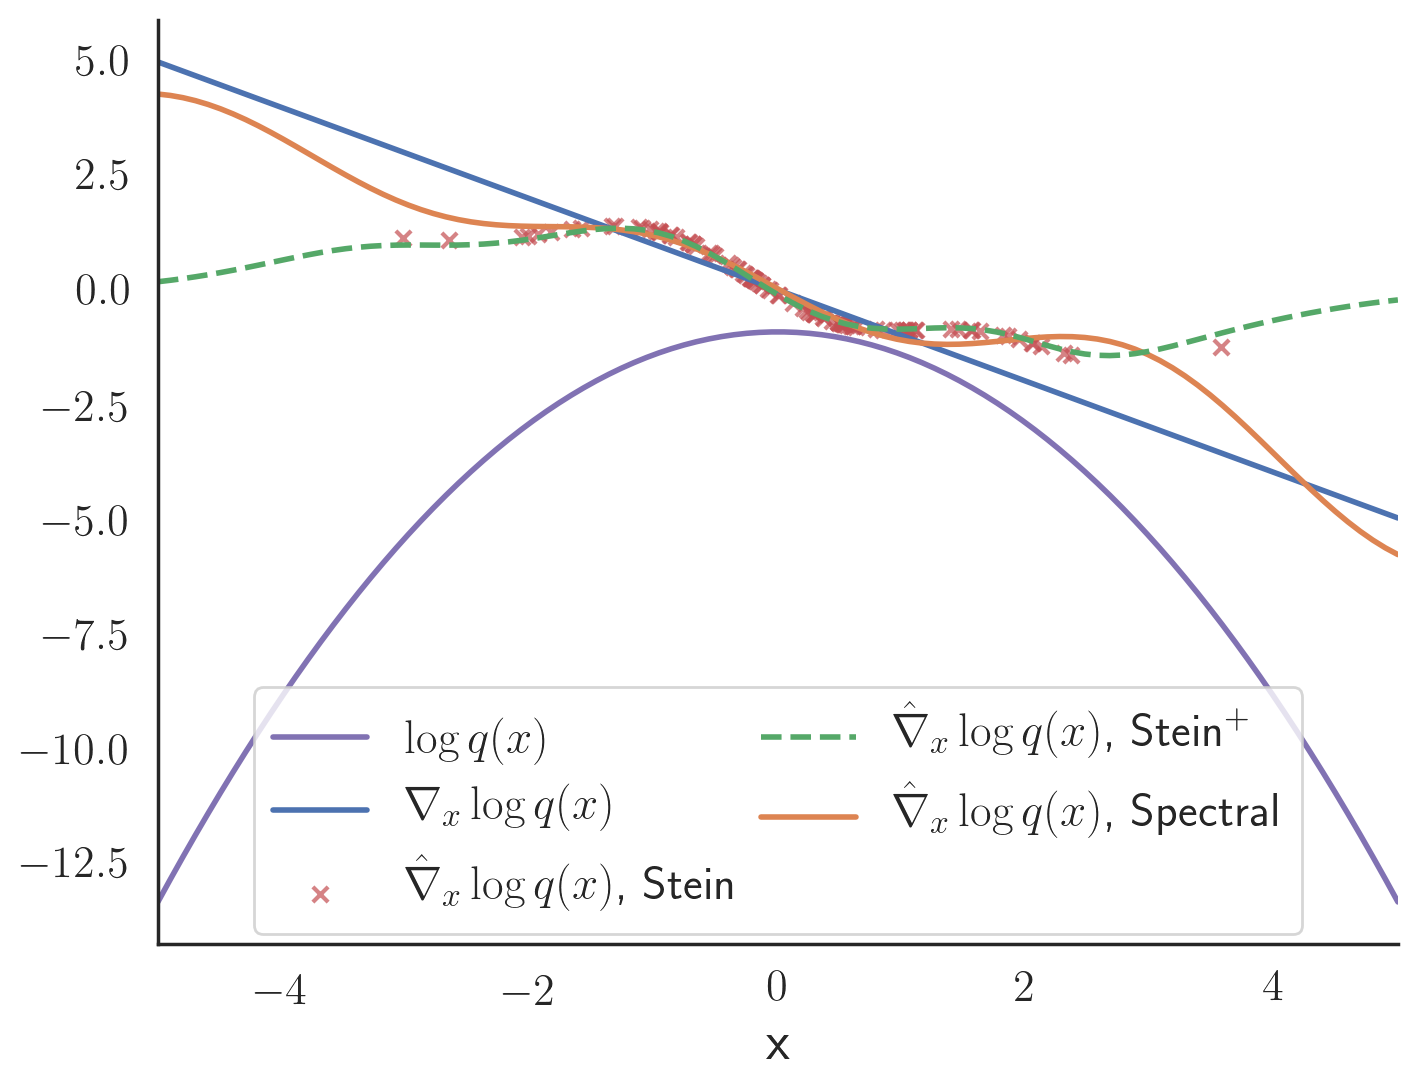

In [8]:
q_mean = 0.
q_logstd = 0.
q_std = np.exp(q_logstd)
q_precision = 1. / q_std ** 2



tf.set_random_seed(1234)
np.random.seed(1234)

from matplotlib import cm, colors, rc
from matplotlib import pyplot as plt
rc('text', usetex=True)

# print(plt.style.available)
import seaborn as sns
sns.set()
sns.set_color_codes()
sns.set_style("white")

eta = 1.
n_eigen = 6
M = 100
lower_box = -5
upper_box = 5

q = zs.distributions.Normal(q_mean, logstd=q_logstd)
# samples: [M]
samples = q.sample(n_samples=M)
# log_q_samples: [M]
log_q_samples = q.log_prob(samples)
# x: [N]
x = tf.placeholder(tf.float32, shape=[None])
# log_qx: [N]
log_qx = q.log_prob(x)
# true_dlog_qx: [N]
true_dlog_qx = tf.map_fn(lambda i: tf.gradients(q.log_prob(i), i)[0], x)

stein = SteinScoreEstimator(eta=eta)
stein_dlog_q_samples = stein.compute_gradients(samples[..., None])
# stein_dlog_q_samples: [M]
stein_dlog_q_samples = tf.squeeze(stein_dlog_q_samples, -1)

def stein_dlog(y):
    stein_dlog_qx = stein.compute_gradients(samples[..., None], x=y[..., None, None])
    # stein_dlog_qx: []
    stein_dlog_qx = tf.squeeze(stein_dlog_qx, axis=(-1, -2))
    return stein_dlog_qx

# stein_dlog_qx: [N]
stein_dlog_qx = tf.map_fn(stein_dlog, x)

spectral = SpectralScoreEstimator(n_eigen=n_eigen)
spectral_dlog_qx = spectral.compute_gradients(samples[..., None],
                                              x=x[..., None])
# spectral_dlog_qx: [N]
spectral_dlog_qx = tf.squeeze(spectral_dlog_qx, -1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    xs = np.linspace(lower_box, upper_box, M)
    log_qxs, true_dlog_qxs, spectral_dlog_qxs, stein_dlog_qxs, stein_dlog_basis, samples_ = \
        sess.run([log_qx, true_dlog_qx, spectral_dlog_qx, stein_dlog_qx, stein_dlog_q_samples, samples], feed_dict={x: xs})

    plt.figure(figsize=(8, 6))
    plt.plot(xs, log_qxs, label=r"$\log q(x)$", linewidth=2., color='m')
    plt.plot(xs, true_dlog_qxs, label=r"$\nabla_x\log q(x)$", linewidth=2.)
    plt.plot(xs, spectral_dlog_qxs, label=r"$\hat{\nabla}_x\log q(x)$, Spectral", linewidth=2.)
    plt.plot(xs, stein_dlog_qxs, "--", label=r"$\hat{\nabla}_x\log q(x)$, Stein$^+$", linewidth=2.)

    sample_idx = np.argsort(samples_)
    samples_ = samples_[sample_idx]
    stein_dlog_basis = stein_dlog_basis[sample_idx]
    plt.scatter(samples_, stein_dlog_basis, marker='x', s=30, alpha=0.7, label=r"$\hat{\nabla}_x\log q(x)$, Stein", color='r')
    plt.xlim(lower_box, upper_box)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1, 4, 3, 2]
    l = plt.legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        fontsize=17, ncol=2, loc="lower center", columnspacing=0.5,
        borderaxespad=0.2,
    )
    plt.setp(l.texts, family='serif', usetex=True)
    plt.xlabel('x', fontsize=20)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.show()
    # plt.savefig('gaussian.pdf', bbox_inches='tight')

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())